First of all, read the data.

In [38]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

test_dirs = os.listdir("input/stage1_test")
test_filenames=["input/stage1_test/"+file_id+"/images/"+file_id+".png" for file_id in test_dirs]
test_images=[cv2.imread(imagefile) for imagefile in test_filenames]

List of operations to be performed on each image

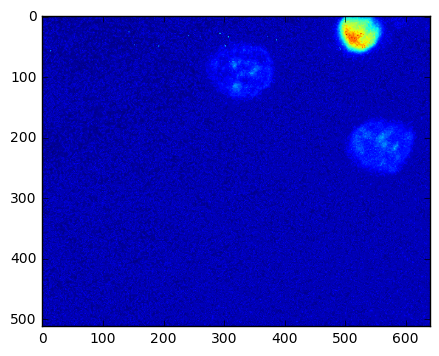

In [51]:
tmp_image_path = np.random.choice(test_filenames)
tmp_image = cv2.imread(tmp_image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(tmp_image)

In [54]:
print(cv2.threshold.__doc__)

threshold(src, thresh, maxval, type[, dst]) -> retval, dst


In [13]:
def process(img_rgb):
    #green channel happends to produce slightly better results
    #than the grayscale image and other channels
    img_gray=img_rgb[:,:,1]#cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #morphological opening (size tuned on training data)
    circle7=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    img_open=cv2.morphologyEx(img_gray, cv2.MORPH_OPEN, circle7)
    #Otsu thresholding
    img_th=cv2.threshold(img_open,0,255,cv2.THRESH_OTSU)[1]
    #Invert the image in case the objects of interest are in the dark side
    if(np.sum(img_th==255)>np.sum(img_th==0)):
        img_th=cv2.bitwise_not(img_th)
    #second morphological opening (on binary image this time)
    bin_open=cv2.morphologyEx(img_th, cv2.MORPH_OPEN, circle7) 
    #connected components
    cc=cv2.connectedComponents(bin_open)[1]
    #cc=segment_on_dt(bin_open,20)
    return cc

#### Computing output for each image

In [18]:
test_connected_components=[process(img)  for img in test_images]

In [26]:
print(np.random.choice([1,2,3,4,5]))

1


In [22]:
def rle_encoding(cc):
    values=list(np.unique(cc))
    values.remove(0)
    RLEs=[]
    for v in values:
        dots = np.where(cc.T.flatten() == v)[0]
        run_lengths = []
        prev = -2
        for b in dots:
            if (b>prev+1):
                run_lengths.extend((b + 1, 0))
            run_lengths[-1] += 1
            prev = b
        RLEs.append(run_lengths)
    return RLEs

test_RLEs=[rle_encoding(cc) for cc in test_connected_components]

#### RLE Encoding
Also known as Run length encoding, a way to encode segmentation information

#### Writing Submission File

In [23]:
with open("submission_image_processing.csv", "a") as myfile:
    myfile.write("ImageId,EncodedPixels\n")
    for i,RLEs in enumerate(test_RLEs):
        for RLE in RLEs:
            myfile.write(test_dirs[i]+","+" ".join([str(i) for i in RLE])+"\n")